In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета Food-101

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]']
)

## Визуализация датасета Food-101

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    version=1.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    urls=['http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 101000,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      author = {Bossard, Lukas and Guilla

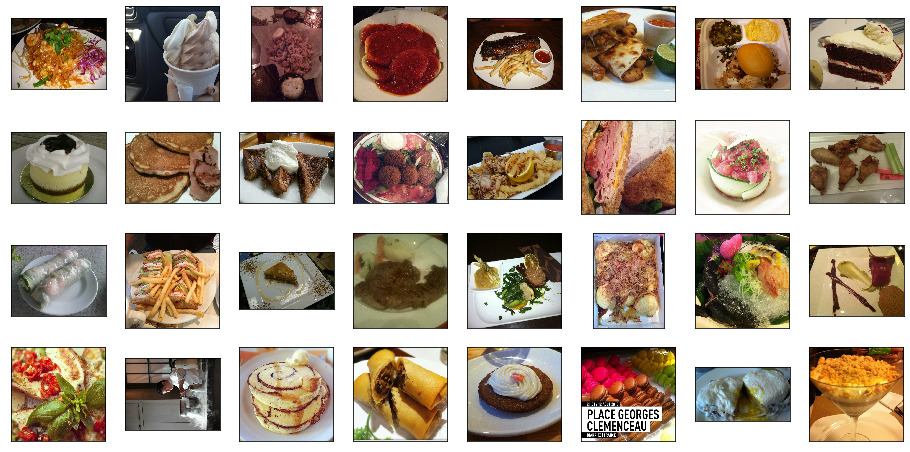

In [4]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание пайплайна данных

In [5]:
INP_SIZE = 160
NUM_EPOCHS = 10
BATCH_SIZE = 128

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

# Подготовка модели CNN

In [6]:
EXP_NAME = 'transfer'
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax'),
])

## Подготовка к обучению

In [7]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

# data augmentation

## Model Summary

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 2,387,365
Trainable params: 2,353,253
Non-trainable params: 34,112
_________________________________________________________________


## Обучение модели

In [9]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/10
710/710 [==============================] - 304s 428ms/step - loss: 2.1079 - accuracy: 0.4904 - val_loss: 1.9248 - val_accuracy: 0.5105
Epoch 2/10
710/710 [==============================] - 292s 412ms/step - loss: 1.1162 - accuracy: 0.7040 - val_loss: 1.4996 - val_accuracy: 0.6083
Epoch 3/10
710/710 [==============================] - 292s 411ms/step - loss: 0.7720 - accuracy: 0.7948 - val_loss: 1.3562 - val_accuracy: 0.6452
Epoch 4/10
710/710 [==============================] - 292s 412ms/step - loss: 0.5314 - accuracy: 0.8621 - val_loss: 1.3793 - val_accuracy: 0.6562
Epoch 5/10
710/710 [==============================] - 291s 410ms/step - loss: 0.3491 - accuracy: 0.9147 - val_loss: 1.4664 - val_accuracy: 0.6491
Epoch 6/10
710/710 [==============================] - 291s 410ms/step - loss: 0.2159 - accuracy: 0.9531 - val_loss: 1.6011 - val_accuracy: 0.6383
Epoch 7/10
710/710 [==============================] - 292s 411ms/step - loss: 0.1281 - accuracy: 0.9755 - val_loss: 1.6919 -

## Оценка качества модели

In [10]:
%%time

model.evaluate(test_ds)

     78/Unknown - 15s 189ms/step - loss: 1.9241 - accuracy: 0.6441Wall time: 14.8 s


[1.9241342911353478, 0.6441306]

## TensorBoard

In [11]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 920), started 2:59:48 ago. (Use '!kill 920' to kill it.)

## Запуск предсказания на нашем изображении

In [12]:
import urllib.request
url = 'http://businesspskov.ru/pictures/140130100410.jpg'
filename = 'borsch.jpg'
urllib.request.urlretrieve(url, filename)

('borsch.jpg', <http.client.HTTPMessage at 0x4359158108>)

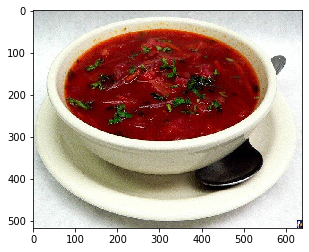

In [13]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

# !wget https://businesspskov.ru/pictures/140130100410.jpg

img = imageio.imread(filename, pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [14]:
pred = model(img[None, ...], training=False)[0]
ans = np.argmax(pred)


print('Prediction: {}'.format(ds_info.features['label'].int2str(ans)))

Prediction: panna_cotta
